# Pairs Trading & Statistical Arbitrage (KO–PEP)


In [1]:
# If needed, install dependencies (run once)
# %pip -q install yfinance statsmodels


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120


## 1) Download & clean data

In [3]:
TICKERS = ["KO", "PEP"]
START = "2015-01-01"
END = None  # or "2026-02-01"

prices = yf.download(TICKERS, start=START, end=END, auto_adjust=True, progress=False)["Close"]
prices = prices.dropna()
prices.tail()

Ticker,KO,PEP
Date,,
2026-02-05,78.510002,167.529999
2026-02-06,79.029999,170.490005
2026-02-09,77.970001,166.470001
2026-02-10,76.809998,166.970001
2026-02-11,76.989998,167.121506


## 2) Quick correlation check

In [4]:
corr = prices["KO"].corr(prices["PEP"])
corr

np.float64(0.8965455416296753)

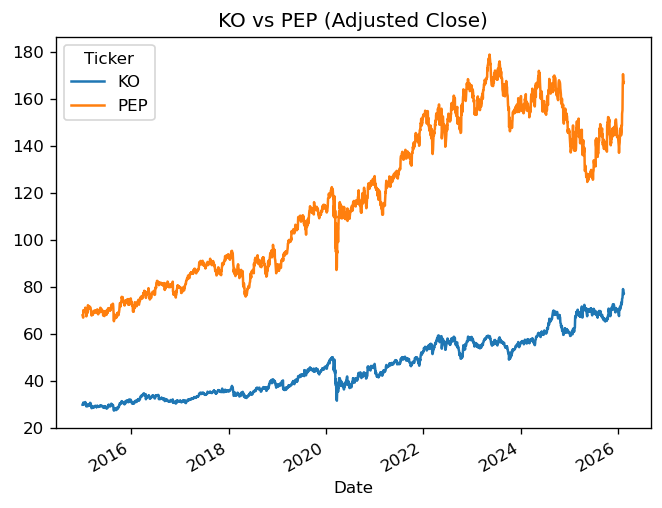

In [5]:
prices.plot(title="KO vs PEP (Adjusted Close)")
plt.show()

## 3) Engle–Granger: estimate hedge ratio + test spread stationarity

In [6]:
def estimate_hedge_ratio(y: pd.Series, x: pd.Series) -> float:
    """OLS: y = a + b x -> hedge ratio b."""
    X = sm.add_constant(x.values)
    model = sm.OLS(y.values, X).fit()
    return float(model.params[1]), model

beta, ols_model = estimate_hedge_ratio(prices["KO"], prices["PEP"])
beta, ols_model.rsquared

(0.3443947091844434, np.float64(0.803793908216048))

In [7]:
spread = prices["KO"] - beta * prices["PEP"]

adf_stat, p_value, *_ = adfuller(spread.dropna())
{"hedge_ratio_beta": beta, "adf_p_value": p_value}

{'hedge_ratio_beta': 0.3443947091844434,
 'adf_p_value': np.float64(0.7532426720424318)}

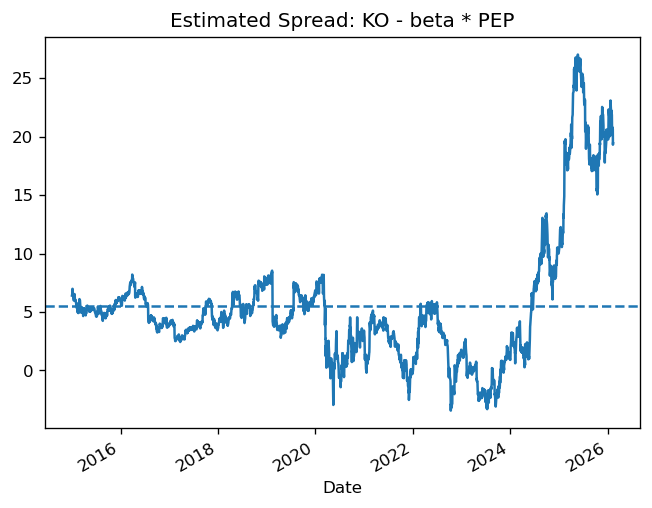

In [8]:
spread.plot(title="Estimated Spread: KO - beta * PEP")
plt.axhline(spread.mean(), linestyle="--")
plt.show()

**Interpretation:**  
- If ADF p-value < 0.05, we reject the unit-root null → spread is likely stationary (cointegrated pair).  
- Hedge ratio beta is the size of the PEP leg per 1 unit of KO leg (in price terms).  


## 4) Rolling z-score (dynamic normalization)

In [9]:
WINDOW = 60  # trading lookback

mu = spread.rolling(WINDOW).mean()
sigma = spread.rolling(WINDOW).std(ddof=0)

z = (spread - mu) / sigma
z = z.dropna()
z.tail()

Date
2026-02-05    0.076388
2026-02-06   -0.335485
2026-02-09   -0.043969
2026-02-10   -1.149965
2026-02-11   -1.009027
dtype: float64

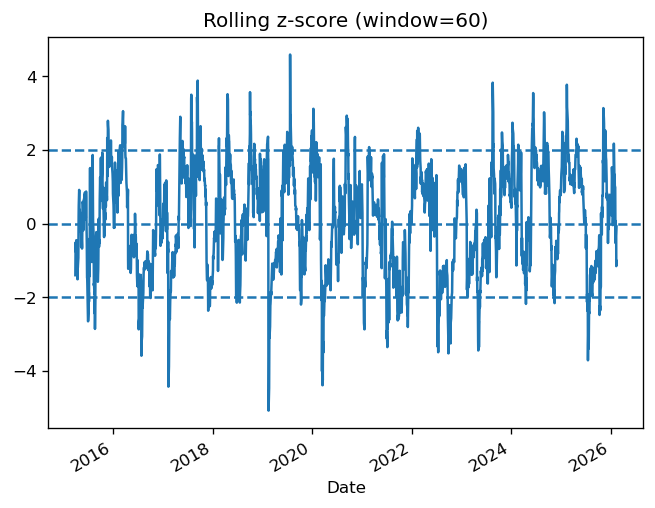

In [10]:
z.plot(title=f"Rolling z-score (window={WINDOW})")
plt.axhline(2, linestyle="--")
plt.axhline(-2, linestyle="--")
plt.axhline(0, linestyle="--")
plt.show()

## 5) Signals (entry/exit)

In [11]:
ENTRY_Z = 2.0
EXIT_Z = 0.5

# Position in spread:
# +1 means LONG spread: long KO, short beta*PEP
# -1 means SHORT spread: short KO, long beta*PEP
pos = pd.Series(0, index=z.index, dtype=float)

in_trade = 0
for t in z.index:
    if in_trade == 0:
        if z.loc[t] <= -ENTRY_Z:
            in_trade = 1
        elif z.loc[t] >= ENTRY_Z:
            in_trade = -1
    else:
        # exit when z-score reverts close to 0
        if abs(z.loc[t]) <= EXIT_Z:
            in_trade = 0
    pos.loc[t] = in_trade

pos.value_counts()

 0.0    1388
-1.0     832
 1.0     515
Name: count, dtype: int64

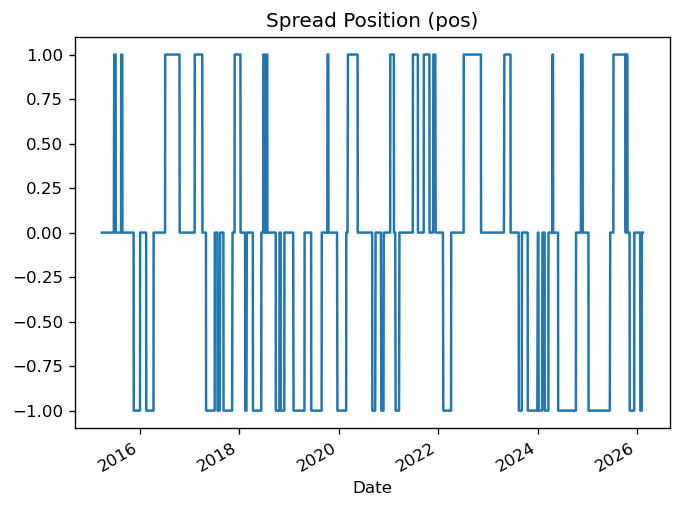

In [12]:
pos.plot(title="Spread Position (pos)")
plt.show()

## 6) Backtest (with costs & slippage)

In [13]:
# Align returns to z/pos index
ret = prices.pct_change().reindex(pos.index).dropna()

# Spread return approximation: r(KO) - beta * r(PEP)
spread_ret = ret["KO"] - beta * ret["PEP"]

# Strategy return using yesterday's position
strat_ret_gross = pos.shift(1).fillna(0) * spread_ret

# Trading costs: apply when position changes
TCOST = 0.0005   # 5 bps per change
SLIPPAGE = 0.0002  # 2 bps per change

turnover = pos.diff().abs().fillna(0)  # 0,1,2 changes (e.g., -1 to +1 -> 2)
costs = turnover * (TCOST + SLIPPAGE)

strat_ret = strat_ret_gross - costs

strat_ret.describe()

count    2735.000000
mean       -0.000156
std         0.006583
min        -0.059503
25%        -0.000700
50%         0.000000
75%        -0.000000
max         0.079737
dtype: float64

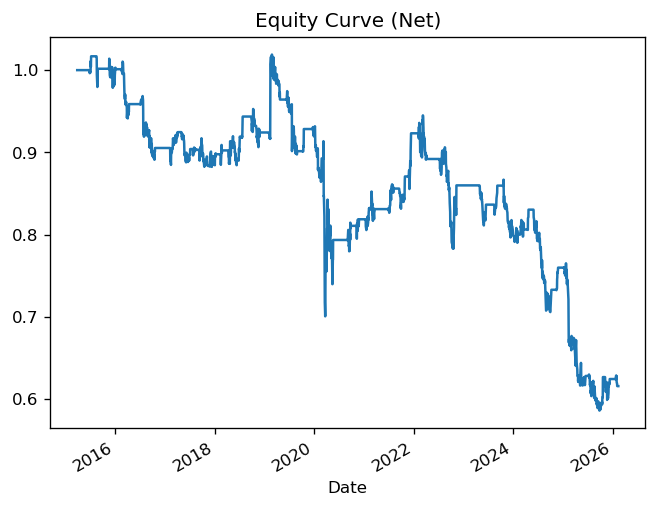

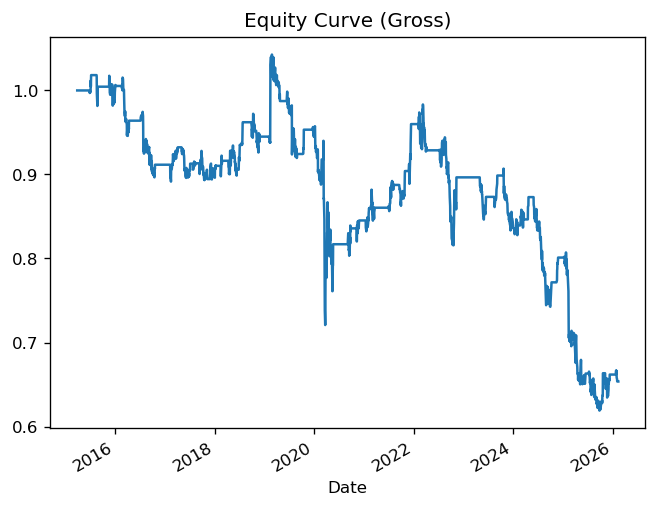

In [14]:
equity = (1 + strat_ret).cumprod()
equity_gross = (1 + strat_ret_gross).cumprod()

equity.plot(title="Equity Curve (Net)")
plt.show()

equity_gross.plot(title="Equity Curve (Gross)")
plt.show()

## 7) Risk controls: stop-loss & max drawdown guardrails

In [15]:
DAILY_STOP = -0.02   # -2% daily stop on strategy return
MDD_LIMIT = -0.10        # stop trading if drawdown below -10%

# Apply daily stop: cap daily returns
strat_ret_stop = strat_ret.copy()
strat_ret_stop[strat_ret_stop < DAILY_STOP] = DAILY_STOP

equity_stop = (1 + strat_ret_stop).cumprod()

# Compute drawdown and apply max drawdown kill-switch (flat after breach)
dd = equity_stop / equity_stop.cummax() - 1
breach = dd < MDD_LIMIT
if breach.any():
    first_breach_date = breach.idxmax()  # first True
    # set returns to 0 after breach (flat)
    strat_ret_kill = strat_ret_stop.copy()
    strat_ret_kill.loc[first_breach_date:] = 0.0
else:
    first_breach_date = None
    strat_ret_kill = strat_ret_stop

equity_kill = (1 + strat_ret_kill).cumprod()

first_breach_date

Timestamp('2016-09-26 00:00:00')

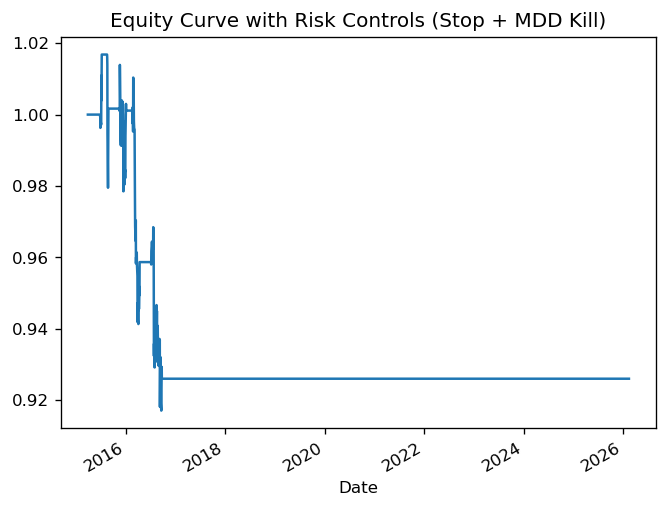

In [16]:
equity_kill.plot(title="Equity Curve with Risk Controls (Stop + MDD Kill)")
plt.show()

## 8) Performance metrics

In [17]:
def perf_stats(r: pd.Series, ann_factor=252) -> dict:
    r = r.dropna()
    mu = r.mean() * ann_factor
    vol = r.std(ddof=0) * np.sqrt(ann_factor)
    sharpe = np.nan if vol == 0 else mu / vol
    
    eq = (1 + r).cumprod()
    dd = eq / eq.cummax() - 1
    mdd = dd.min()
    
    win_rate = (r > 0).mean()
    return {
        "Ann. Return": float(mu),
        "Ann. Vol": float(vol),
        "Sharpe": float(sharpe),
        "Max Drawdown": float(mdd),
        "Win Rate": float(win_rate),
        "Total Return": float(eq.iloc[-1] - 1),
        "Days": int(r.shape[0]),
    }

pd.DataFrame({
    "Gross": perf_stats(strat_ret_gross),
    "Net": perf_stats(strat_ret),
    "Risk-Controlled": perf_stats(strat_ret_kill),
}).T

,Ann. Return,Ann. Vol,Sharpe,Max Drawdown,Win Rate,Total Return,Days
Gross,-0.033711,0.104633,-0.322184,-0.406431,0.233638,-0.346416,2735.0
Net,-0.039258,0.104480,-0.375746,-0.425187,0.232907,-0.384501,2735.0
Risk-Controlled,-0.006816,0.023245,-0.293211,-0.098150,0.022303,-0.074028,2735.0
